# The Matched Filter 

This notebook aims to illustrate the function and properties of the matched filter in the digital baseband processing of a receiver. The development is specialized for quadrature-amplitude modulated (QAM) signals. We will also learn how to estimate receiver performance through Monte Carlo Simulation.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/020_matched_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/020_matched_filter.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [3]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Quadrature-Amplitude Modulation

Passband signals can carry to channels over the same band of frequencies. The two channels are referred to as the *in-phase* and *quadrature* channel, repsectively. 

At digital baseband, the two channels simply map to the real and imaginary parts of the (complex) baseband signal. Based on these observations, QAM signals combine three "ingredients":

* a constellation $\cal A$ that enumerates a set of $L=2^M$ complex symbols $\{s_l\}$
* a pulse shape $p(t)$ that is used to convert a sequence of symbols $s_n \in {\cal A}$ into an analog baseband signal $s(t)$
* the symbol period $T$ is the time between the transmission of two consecutive symbols; $1/T$ is the symbol (or baud) rate and $M/T$ is the bit rate.

Specifically, the signal $s(t)$ is constructed from the symbols $s_n$ and the pulse shape $p(t)$ as
$$
    s(t) = \sum_n s_n \cdot p(t-nT)
$$

We define two simple pulse for use in our experiments.

### Triangular Pulse

Most pulses used for pulse shaping in digital communications systems are nearly always symmetric. The pulse below is intentionally non-symmetric. We will use it later to make an important point about the matched filter.

In [65]:
def triangular_pulse(fsT, center=0.25):
    """Generate a non-symmetric triangular pulse
    
    The pulse spans from -T/2 to T/2 and has its peak at center*T.

    Inputs:
    fsT - integer number of samples per symbol period T
    center - peak is located at center*T (must be in range (-0.5, 0.5) )

    Returns:
    Numpy array with fsT+1 samples (the sample at time t=T is included)
    """
    tt = np.arange(fsT+1)/fsT - 0.5
    pp = np.empty_like(tt)

    n = 0

    m = 1 / (center + 0.5)
    b = m / 2
    while tt[n] <= center:
        pp[n] = m * tt[n] + b
        n += 1

    m = -1 / (0.5 - center)
    b = -m / 2
    while n < len(tt):
        pp[n] = m * tt[n] + b
        n += 1

    return pp/np.linalg.norm(pp)

Text(0.5, 0, 'Time')

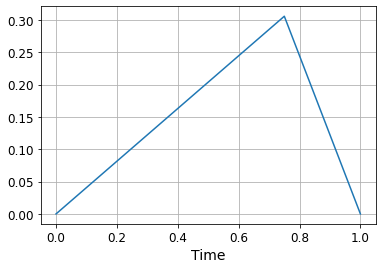

In [66]:
fsT = 32
tt = np.arange(fsT+1)/fsT

plt.plot(tt, triangular_pulse(fsT))
plt.grid()

plt.xlabel('Time')

### Half-Sine Pulse

A more common and symmetric pulse shape is the half-sine pulse.
$$ 
p(t) = \sqrt{\frac{2}{T}} \sin(\frac{\pi t}{T})
$$
Below is a function to generate that pulse (for $T=1$)

In [52]:
def half_sine_pulse(fsT):
    """Generate a pulse that is shaped like a half cycle of a sinusoid
    
    Inputs:
    fsT - number of samples per symbol period

    Returns:
    Numpy array with fsT+1 samples (the sample at time t=T is included)
    """

    tt = np.arange(fsT+1) / fsT
    return np.sqrt(2/fsT) * np.sin(np.pi*tt)


Text(0.5, 0, 'Time')

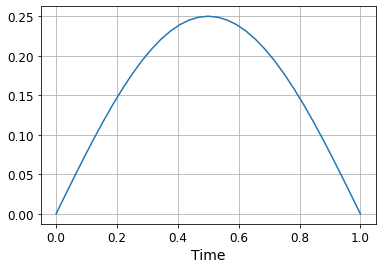

In [53]:
fsT = 32
tt = np.arange(fsT+1)/fsT

plt.plot(tt, half_sine_pulse(fsT))
plt.grid()

plt.xlabel('Time')

### Transmitter Pulse Shaping

With two pulse-shapes in hand, we can now generate a signal $s(t)$ that is to be transmitted for a given sequences of informations symbols $s_n$. To keep the signal real-valued (for plotting), we choose real-valued symbols.

The digital pulse shaping is a simple two-step process:

1. The sequence of symbols is upsampled to the same rate as the pulse, i.e., to `fsT` samples per symbol. This is accomplished by inserting $f_sT-1$ 0s between symbols.
2. Then the upsampled symbol sequence is filtered (convolved) with the pulse signal.

Here is a function to do that:

In [59]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

Before generating a transmitted signal, we define a function to generate random symbols from a given constellation.

In [71]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

And, here is a signal with 10 random BPSK symbols and pulse shaping using the half-sine pulse.

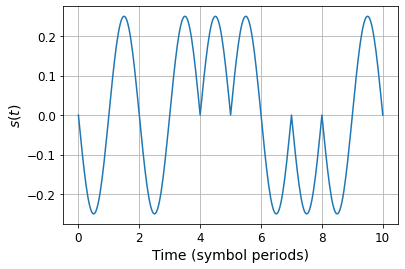

Symbols =  [-1  1 -1  1  1  1 -1 -1 -1  1]


In [72]:
# generate 10 random BPSK symbols
A = np.array([1, -1])                        # define a BPSK constellation
sym =  random_symbols(A, 10) # select 10 symbols at random

# pulse shape with half-sine pulse
pp = half_sine_pulse(fsT)
ss = pulse_shape(sym, pp, fsT)
tt = np.arange(len(ss))/fsT

# and plot
plt.plot(tt, ss)
plt.grid()

plt.xlabel('Time (symbol periods)')
plt.ylabel('$s(t)$')

plt.show()

print('Symbols = ', sym)

In the plot above, the individual pulses are clearly visible. The polarity of the individual pulses is provided by the elements of the information sequence that is printed below the plot. 

We will use highly oversampled signals, like the one above, to approximate the continuous time signals that the receiver encounters.

## Matched Filter for QAM Signals

The matched filter has an impulse response that is the time-reversed, conjugate of the transmit pulse, $h(t) = p^*(-t)$. To make the filter causal, we must delay it by $T$T, so that $h(t) = p^*(T-t)$. To account for this delay, all samples at the filter output must be delayed by $T$ (`fsT` samples).

In our first experiment, we pass the transmitted signal $s(t)$ through the matched filter an plot the filter output. The sampling instances $nT$, for $n=1,2,\ldots, 10$ are marked in the plot. Recall that we must start sampling at $t=T$ because of the delay induced by the causal filter.

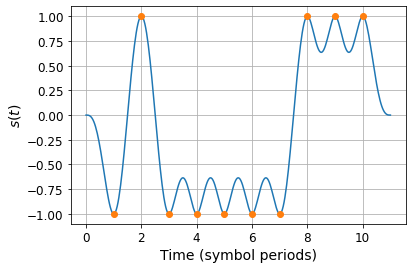

matched filter samples at nT =  [-1.  1. -1. -1. -1. -1. -1.  1.  1.  1.]


In [70]:
# define the matched filter's impulse response
mf = np.flip(np.conj(pp))

# pass s(t) through the matched filter
mf_out = np.convolve(ss, mf)

# plot it
tt = np.arange(len(mf_out))/fsT
plt.plot(tt, mf_out)                                   # plot output from MF
plt.plot(tt[fsT:-fsT:fsT], mf_out[fsT:-fsT:fsT], 'o')  # plot samples
plt.grid()

plt.xlabel('Time (symbol periods)')
plt.ylabel('$s(t)$')

plt.show()

print('matched filter samples at nT = ', mf_out[fsT:-fsT:fsT])

The matched filter output has maxima at the sampling locations, i.e., at $nT$. At these instances, the filter outputs have the values 
$$
    s_n \cdot \int_{nT}^{(n+1)T} |p(t-nT)|^2 \, dt = s_n \cdot \int_{0}^{T} |p(t)|^2 \, dt \approx s_n \cdot \sum_{m=0}^{f_s T} |p[m]|^2 \text{, where}
$$
$s_n$ denotes the $n$-th information symbol. Whwn the energy of the pulse is normalized ($\int_{0}^{T} |p(t)|^2 \, dt=1$) then the matched filter outputs at the sampling locations are equal to the information symbols $s_n$

Both the continuous-time and the discrete-time matched filters generate (approximately) the same output, especially when the oversampling factor `fsT` is large.

### Time-reversal is important

The half-sine pulse considered so far is symmetric, $p(t)=p(T-t)$. Hence, the experiment above does not prove that the matched filter uses the time-reversed pulse for its impulse response.

With the help, of the non-symmetric triangular pulse we can demonstrate that time-reversal is essential. We will generate a baseband siganl $s(t)$ that is pulse-shaped by the trinagular pulse. Then we pass $s(t)$ through the matched filter ($p(T-t)$) and through the original pulse ($p(t)$).

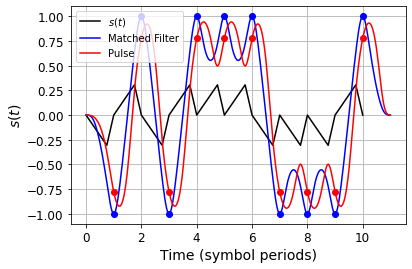

In [78]:
# pulse shape with half-sine pulse
pp = triangular_pulse(fsT)
ss = pulse_shape(sym, pp, fsT)
tt = np.arange(len(ss))/fsT

# and plot
plt.plot(tt, ss, 'k')

# pass trough matched filter
mf = np.flip(np.conj(pp))
mf_out = np.convolve(ss, mf)

# plot that
tt = np.arange(len(mf_out))/fsT
plt.plot(tt, mf_out, 'b')                                   # plot output from MF

# pass through p(t)
p_out = np.convolve(ss, pp)

# plot that, too
plt.plot(tt, p_out, 'r')                                   # plot output from MF

plt.legend(['$s(t)$', 'Matched Filter', 'Pulse'])

plt.plot(tt[fsT:-fsT:fsT], mf_out[fsT:-fsT:fsT], 'bo')     # plot samples
plt.plot(tt[fsT:-fsT:fsT], p_out[fsT:-fsT:fsT], 'ro')   

plt.grid()

plt.xlabel('Time (symbol periods)')
plt.ylabel('$s(t)$')

plt.show()



The plot shows the transmitted signal as well as the output from filters with impulse responses $h(t)=p(T-t)$ (in blue) and $h(t)=p(t)$ (in red), respectively. Only the matched filter produces 

* extrema at the sampling locations with
* sample values equal to the symbols $s_n$

This experiment demonstrates that the matched filter must have an impulse response that's the time-reverse of the transmit pulse: $h(t)=p(T-t)$.

## Signal plus Noise through the Matched Filter

Additive, white Gaussian noise is a main limitation in any communication system. We demonstrate what happens as noise passes through the matched filter. 

When simulting noise, we have principally two options:
1. simulate signal and noise power levels faithfully. This approach is particularly useful and important when details of the analog receiver frontend are to be included. This includes non-linear distortions and automatic gain control.
2. Focus on signal-to-noise ratio (SNR). We know that the error performance depends only on SNR and more specifically, on the ratio of bit energy $E_b$ or symbol energy $E_s$ to noise power spectral density $N_0$. Hence, when error-rate is the only concerm we can choose power levels for signal and noise arbitrarily as long as the SNR is correct.

A final consideration to understand properly is the role that the sampling rate plays in simulating received signals.

### Simulating accurate power levels

We illustrate by example how to simulate a received signal with power levels that correspond to levels that might be seen at the input to the receiver. This kind of simulation is most appropriate when the analog frontend is to be included in the simulation. The received signal is specified as follows:

* symbol rate $1/T = 1 \text{MHz}$
* pulse-shaping with half-sine pulses
* received signal power $P_r=-100 \text{dBm}$
* noise is AWGN and tempaerature is 300K
* receiver noise figure is 2dB
* signal is oversampled 8-fold, i.e., $f_s=8/T = 8 \text{MHz}$

In [105]:
# parameters
T = 1e-6
fsT = 8
pp = half_sine_pulse(fsT)
Pr_dBm = -100
N0_dBm = -174 + 2    # thermal noise plus noise figure

fs = fsT/T

# convert dB to linear (scale is milliWatt)
Pr = 10**(Pr_dBm/10)
N0 = 10**(N0_dBm/10)

#### Simulating the signal

We have seen above how to generate signals $s(t)$ from a given information symbol sequence $\{s_n\}$ and a pulse shape $p(t)$. To set the signal power, we must scale the amplitde of this signal.

When both the alphabet and the pulse shape are normalized to unit power, then it will be sufficient to multiply the signal by $\sqrt{P_r}$. Clearly, $P_r$ must be converted to a linear scale first. Note that the normalization for the pulses above scales the energy to unity!

Otherwise, the signal must first be scaled to unit power before multiplying by $\sqrt{P_r}$. To normalize the signal to unit power, it is divided by the square root of the power, i.e., if $s(t)$ denotes the unscaled signal then $s(t)$ must be divided by
$$
    \frac{1}{NT} \int_0^{NT} |s(t)|^2 \, dt \approx \frac{1}{N f_s T} \sum_{m=0}^{N fs T - 1} |s(m/f_s)|^2 \approx \text{, where}
$$
$N$ denotes the number of symbols in $s(t)$

In [108]:
# generate signal
N = 256   # number of symbols
A = np.array([1+1j, 1-1j, -1+1j, -1-1j])  # define a QPSK constellation
sym =  random_symbols(A, N)

ss = pulse_shape(sym, pp, fsT)

# normalize to unit power 
ss_pwr = np.mean(ss * ss.conj()).real
ss = ss/np.sqrt(ss_pwr)

# scale to desired power level
ss = np.sqrt(Pr) * ss

print("Power of scaled signal ", 10*np.log10(np.var(ss)), "dBm")

Power of scaled signal  -100.02402619833842 dBm


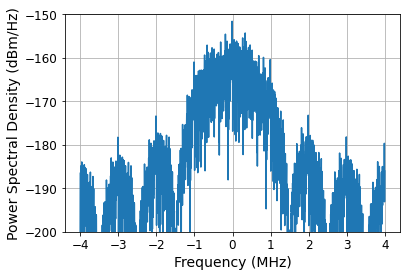

In [109]:
# plot PSD
Ns = N*fsT   #number of samples
# first compute the FFT, scaled by sqrt(N) to make it a unitary transform
SS = np.fft.fftshift(np.fft.fft(ss, Ns))/np.sqrt(Ns)

# then take magnitude squared and dived by fs to produce a PSD
PSD = np.abs(SS)**2 / fs

# frequency axis
ff = (np.arange(Ns) - Ns//2)*fs/(Ns)

# plot
plt.plot(ff/1e6, 10*np.log10(PSD))
plt.grid()

plt.ylim([-200,-150])
#plt.xlim([-0.1/2, 0.1/2])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dBm/Hz)')

plt.show()

This power spectral density plot is very noisy because it is based on a single *Periodogram*. A periodogram is the squared magnitude of the DFT. To make the PSD estimate more reliable, several periodograms of different signal segments should be averaged. This is called Welch's method. The function `plt.psd` implements this method and yields a less noisy estimate (see below).

The width of the man lobe in the PSD plot is approximately 2 MHz, i.e., $2/T$. This is due to data rate and the chosen pulse shape. The height of the peak is at -160dBm, which is the received power level (-100dBm) minus the symbol rate in dBHz ($10\log_{10}(1 \text{MHz})$). Recall that the power $P$ of a signal $s(t)$ is related to the power spectral density $S^2(f)$ by
$$
    P = \int S^2(f) \, df.
$$

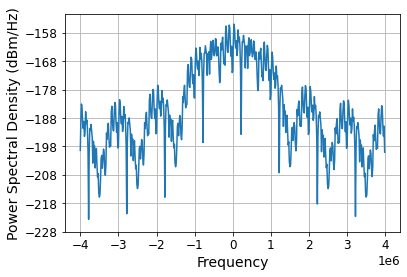

In [104]:
plt.psd(ss, 512, fsT/T)
plt.ylabel('Power Spectral Density (dBm/Hz)')
plt.show()

#### Simulating the Noise

IN a digital simulation, the noise must necessarily be converted to discrete-time, i.e., to noise samples. The variance of the noise samples equals the noise power in the observed band, i.e., between $-f_s/2$ and $f_s/2$. Hence, the variance of the noise samples must equal $N_0f_s$. 

The increase with $f_s$ should make intuitive sense: the wider the observed bandwidth, the more noise is admitted.

Recall that noise is complex-valued and that I and Q channels have equalpower spectral density $N_0/2$.

These observations suggests that we can simulate additive noise (of the same dimension as the signal) as follows:

In [117]:
noise = np.sqrt(N0*fs/2) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))

We can now compute the power spectral density of the noisy signal (using the `plt.psd` function for simplicity).

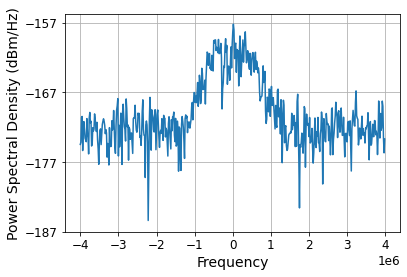

In [119]:
# plot the PSD of signal plus noise
plt.psd(ss + noise, 512, fsT/T)
plt.ylabel('Power Spectral Density (dBm/Hz)')
plt.show()

We can see  the noise floor at a level of -172dBm. The noise floor covers the side-lobes of the signal. 

Only the main lobe of the signal sticks out from the noise floor. The height of the signal peak above the noise floor is approximately 12dB (-160dB/Hz versus -172dBm/Hz). We can make this measurement more precise by noting that 

* $E_s = P_r \cdot T = \frac{1}{N} \int_0^{NT} \, dt$ is the average symbol energy. On a dB scale, $E_s$ equals $E_s = P_r + 10\log_{10}(T) \text{dBm/Hz}$. For the assumed values, $E_s=-160dBm/Hz$. Thus, the height of the signal peak in the PSD plot reflects the average symbol energy. And, the difference between the height of the signal peak and the noise floor is $E_s/N_0$.
* Alternatively, since the signal bandwidth is approximately $1/T$, the noise power $P_n$ in the signal bandwidth is approximately equal to $P_n=N_0/T$. On a dB scale, $P_n = N_0 - 10\log_{10}(T)$. For the assumed values, $P_n=-112 \text{dBm}$. Thus, the ratio of signal power and **in-band** noise power is again 12dB.


### Simulating SNR only

When accurate signal levels are not important and only the dependence of error rates on SNR is desired, then the generation of signal and noise can be simplified.

Typically, the signal is scaled such that the average symbol energy of the sampled signal is unity. This happens automatically when the pulse is normalized so that $\sum_n |p[n]|^2 = 1$ and the constellation $\cal A$ is normalized so that $\frac{1}{|{\cal A}|} \sum_{l \in {\cal A}} |s_l|^2 = 1$.

In comparison to accurate power levels, the signal power is scaled by $1/(P_r f_sT)$ to yield a signal with $E_s=1$. Applying the same scaling to the noise, yields a 
variance of noise samples $\sigma_n^2$ 
$$
    \sigma^2 = \frac{N_0 f_s}{P_r f_s T} = \frac{N_0}{P_r T} = \frac{N_0}{E_s} = \frac{1}{\text{SNR}}.
$$

Note, in particular, that this paramerization is independent of the symbol duration $T$. Even the dependence onthe oversampling factor $f_sT$ is obscured by working with signal energy instead of power. The peak of the PSD will be at $1/f_sT$.

In [154]:
# parameters
fsT = 8
pp = half_sine_pulse(fsT)   # this is normalized to unit energy
SNR_dB = 12

SNR = 10**(SNR_dB/10)

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
sym = random_symbols(A, N)

# make the signal
ss = pulse_shape(sym, pp, fsT)
print("average symbol energy: ", 1/N*np.sum(np.abs(ss)**2))

# noise variance
var_n = 1/SNR
noise = np.sqrt(var_n/2) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))

average symbol energy:  0.9999999999999996


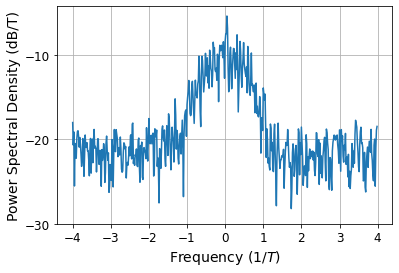

In [155]:
# plot the PSD of signal plus noise
plt.psd(ss*np.sqrt(1)+noise , 512, fsT)
plt.ylabel('Power Spectral Density (dB/T)')
plt.xlabel('Frequency ($1/T$)')
plt.show()

The PSD plot has the same shape as the plots with accurate power levels. However, the plot is shifted up to near 0 dBm/T. For simulating error rates, there is no difference since the SNR is the same for both cases.

#### Noisy Signal through matched filter

When this noisy signal is passed through the matched filter and then sampled, it produces the decision statistic. The decision statistic contains all relevant information about the information symbols $s_n$.

We take two different looks at the matched filter outputs:
1. **Eye diagram:** is a repeated plot of two consecutive symbol periods of the matched filter output. These plots are super imposed and form a shape that resembles a pair of eyes.
2. **Constellation plot:** is simply a scate plot of the sampled matched filter outputs

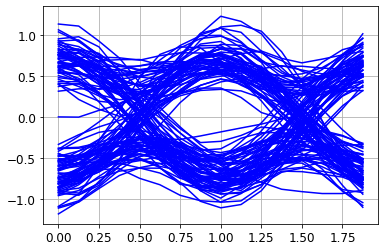

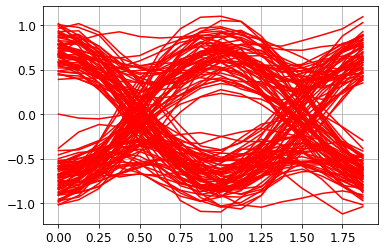

In [165]:
# Apply matched filter
mf = np.flip(pp)
mf_out = np.convolve(ss + noise, mf)

# Eye Diagram plot of real part only
for n in range(len(ss)//(2*fsT)):
    plt.plot(np.arange(2*fsT)/fsT, np.real(mf_out[n*2*fsT:(n+1)*2*fsT]), 'b')

plt.grid()
plt.show()

# Eye Diagram plot of imaginary part only
for n in range(len(ss)//(2*fsT)):
    plt.plot(np.arange(2*fsT)/fsT, np.imag(mf_out[n*2*fsT:(n+1)*2*fsT]), 'r')

plt.grid()
plt.show()


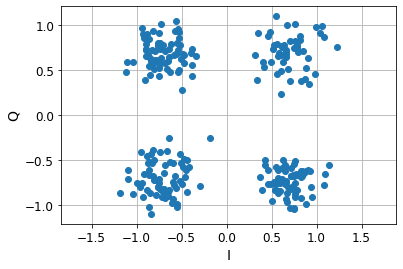

In [170]:
# Constellation Plot
Z = mf_out[fsT:-fsT:fsT]

plt.plot(np.real(Z), np.imag(Z), 'o')
plt.grid()

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()